In [1]:
# Standard library imports
from typing import Type, Any

# Third-party imports
import numpy as np
from numpy._typing import _ShapeLike
import torch
import torch.nn as nn
import gym_agent as ga

from tqdm.notebook import tqdm_notebook as tqdm


In [2]:
class DeepQNetwork(nn.Module):
    def __init__(self, n_inp: int, features: list[int]):
        super().__init__()

        # Create a list of layer sizes including input, hidden, and output layers
        layer_sizes = [n_inp] + features
        # print(layer_sizes)

        # Initialize an empty sequential container
        self.net = nn.Sequential()

        # Loop through the layer sizes to create the network
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            self.net.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            self.net.append(nn.ReLU())

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        # Pass the input state through the network
        return self.net(state)

In [3]:
from typing import overload
from torch.distributions import Categorical
class lunarlender_policy: 
    def __init__(self, n_inp: int, features: list[int], action_shape, action_std: float = 0.6, device = 'cpu'):
        # Separate encoders for actor and critic
        self.actor_encoded = DeepQNetwork(n_inp, features)  
        self.critic_encoded = DeepQNetwork(n_inp, features) 

        self.actor = nn.Sequential(self.actor_encoded,
                                   nn.Linear(features[-1], out_features=4), 
                                   nn.Softmax(dim=1))
        self.critic = nn.Sequential(self.critic_encoded, 
                                    nn.Linear(features[-1], out_features=1)
                                    )
        self.actor.to(device) 
        self.critic.to(device)
        self.device = device
    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_val = self.critic(state)
        return action_logprobs, state_val, dist_entropy    
    
    @overload
    def load_state_dict(self, policy) -> None: ...

    @overload 
    def load_state_dict(self, checkpoint_path) -> None: ... 

    def load_state_dict(self, a):  
        try:
            if isinstance(a, lunarlender_policy):  # Use isinstance for type checking
                # Load actor and critic state dicts from another model
                self.actor.load_state_dict(a.actor.state_dict())
                self.critic.load_state_dict(a.critic.state_dict())
                # print("Loaded state dict from lunarlender_policy object successfully.")
            
            elif isinstance(a, str):  # Check if it's a file path (string)
                checkpoint = torch.load(a, map_location=self.device)  # Load the checkpoint to the correct device
                self.actor.load_state_dict(checkpoint['actor'])
                self.critic.load_state_dict(checkpoint['critic'])
                # print("Loaded state dict from checkpoint successfully.")
            else:
                raise TypeError("Input must be either a lunarlender_policy object or a file path (string).")
        
        except (FileNotFoundError, KeyError) as e:
            print(f"Loading error: {e}. Check file path or checkpoint contents.")
        except Exception as e:
            print(f"Unexpected error occurred while loading state dict: {e}")

    


In [4]:
import torch.nn as nn 
from torch.distributions import MultivariateNormal, Categorical
from torch.optim.lr_scheduler import OneCycleLR
class PPOAgent(ga.AgentBase): 
    def __init__(self,
            state_shape: _ShapeLike,
            action_shape: _ShapeLike,
            features: list[int],
            batch_size: int,
            buffer_size: int,
            update_every: int,
            device: str,
            seed,
            is_continuous=False,
            **kwargs) -> None: 
        # Explicitly pass `on_policy` and `buffer_size`
        super().__init__(state_shape, action_shape, batch_size, on_policy=True, buffer_size=buffer_size, update_every=update_every, device=device, seed=seed)
        
        self.is_continuous = is_continuous
        self.lr_critic = kwargs.get('lr_critic', 5e-4)
        self.lr_actor = kwargs.get('lr_actor', 5e-4)
        self.gamma = kwargs.get('gamma', 0.99) 
        self.action_std = kwargs.get('action_std', 0.6) 
        self.eps_clip = kwargs.get('eps_clip', 0.2) 
        self.lamda = kwargs.get('lamda', 0.9)
        self.k = kwargs.get('k', 10)
        self.n_inp = state_shape[0]

        self.policy = lunarlender_policy(self.n_inp, features, action_shape=action_shape, device=device)
        self.policy_old = lunarlender_policy(self.n_inp, features, action_shape=action_shape, device=device)
        # self.policy_old.load_state_dict(self.policy)
        self.loss = nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': self.lr_actor},  # Actor encoder parameters
            {'params': self.policy.critic.parameters(), 'lr': self.lr_critic},  # Critic encoder parameters
        ])

        # Define OneCycleLR scheduler
        self.scheduler = OneCycleLR(self.optimizer, max_lr=[self.lr_actor, self.lr_critic], 
                                    steps_per_epoch=100, epochs=10)  # adjust 'epochs' as needed
        

        self.loss_arr = []
        self.dist_entropy = []

        # # Initialize TensorBoard SummaryWriter
        # self.writer = SummaryWriter('runs/ppo_experiment') 
        # self.global_step = 0  # Initialize global step counter


        self.set_action_var(self.action_std)


    def set_action_var(self, new_action_std):
        self.action_std = new_action_std
        self.action_var = self.action_std**2
    @torch.no_grad()
    def act(self, state: np.ndarray) -> np.ndarray: 
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        self.policy_old.actor.eval()
        
        if self.is_continuous:
            action_mean = self.policy_old.actor(state)
            cov_mat = torch.diag(torch.tensor([self.action_var] * action_mean.shape[-1])).to(self.device)  # Ensure action_var matches action dim
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.policy_old.actor(state)
            dist = Categorical(action_probs)  # Ensure action_probs are properly normalized (softmax if necessary)
        
        action = dist.sample()
        
        return action.detach().cpu().numpy()[0]


    def TD_residual(self, rewards: torch.Tensor, states_values: torch.Tensor, next_states_values: torch.Tensor) -> torch.Tensor:
        res = rewards + self.gamma * next_states_values - states_values
        return res

    def GAE(self, states:torch.Tensor, next_states: torch.Tensor, rewards:torch.Tensor, terminals:torch.Tensor): 
        '''Calcualte general advantage estimation'''
        ratio = self.gamma * self.lamda
        advantages = []
        discounted_sum = 0
        for state, next_state, reward, terminal in zip(reversed(states), reversed(next_states), reversed(rewards), reversed(terminals)): 
            if terminal: 
                discounted_sum = 0 
            state_value = self.policy_old.critic(state) 
            next_state_value = self.policy_old.critic(next_state)
            discounted_sum = self.TD_residual(reward, state_value, next_state_value) + ratio*discounted_sum
            advantages.insert(0, discounted_sum)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return advantages

    def returns_estimate(self, rewards: torch.Tensor, terminal: torch.Tensor, old_state_values: torch.Tensor, return_advantage = False) ->torch.Tensor:
        '''Using Monte Carlo to approximate advantage''' 
        # Calculate discounted returns
        returns = []
        discounted_sum = 0
        for r, done in zip(reversed(rewards), reversed(terminal)):
            if done:
                discounted_sum = 0
            discounted_sum = r + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        # Normalize returns
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        if return_advantage: 
            advantage = returns - old_state_values.detach() 
            return returns, advantage
        return returns

    def learn(self, states, actions, rewards, next_states, terminal, using_gae = True) -> None:
        states = states.detach().squeeze(-1).to(self.device)
        actions = actions.detach().squeeze(-1).to(self.device)
        # Evaluate current and old policies
        old_logprobs, old_state_values, _ = self.policy_old.evaluate(states, actions)
        # detach all the values, so it does not change in backward call 
        old_logprobs = old_logprobs.detach().to(self.device)  # Fix: unsqueeze old_logprobs
        # Calculate advantage, returns. 
        if using_gae: 
            advantage = self.GAE(states=states, next_states=next_states, terminals=terminal, rewards=rewards).detach().to(self.device)
            returns = self.returns_estimate(rewards, terminal, old_state_values, return_advantage=False).detach().to(self.device)

        else: 
            returns, advantage = self.returns_estimate(rewards, terminal, old_state_values, return_advantage=True)
            returns = returns.detach().to(self.device)
            advantage = advantage.detach().to(self.device)
        

        for i in range(self.k):
            print(states.shape, actions.shape)
            logprobs, state_values, dist_entropy = self.policy.evaluate(states, actions)

            # Set networks to training mode
            self.policy.actor.train()
            self.policy.critic.train()

            # PPO ratio
            ratio = torch.exp(logprobs - old_logprobs)

            # Surrogate loss
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantage

            # Total loss
            loss = (-torch.min(surr1, surr2) + 0.5 * self.loss(returns, state_values.squeeze(-1)) - 0.05 * dist_entropy).mean()

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(self.policy.actor.parameters(), max_norm=0.5)
            torch.nn.utils.clip_grad_norm_(self.policy.critic.parameters(), max_norm=0.5)
            self.optimizer.step()
            if (i+1)%10 == 0: 
                self.scheduler.step()

        # Update old policy
        self.policy_old.load_state_dict(self.policy)

        # Append loss for visual repr
        self.loss_arr.append(loss)
        self.dist_entropy.append(dist_entropy.mean())



In [5]:
agent = PPOAgent(
    gamma=0.99,
    batch_size = False,
    state_shape = (8,),
    action_shape=(1,),
    features=[128, 128],
    buffer_size=int(1e5),
    update_every=100,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    seed = 42,
    lr_critic=1e-3,
    lr_actor = 1e-3,
    eps_clip = 0.2, 
    lamda=0.9, 
    k = 10,
    is_continuous=False
)

agent.apply(ga.init_weights)

(1,)


In [6]:
n_games, max_t = 1000, 1000
chkpt_dir = 'checkpoints/'

env_id = 'LunarLander-v2'

In [7]:
# Create a new environment instance
env = ga.make(env_id)

# Define a custom reward transformation class
class RewardTransform(ga.Transform):
    def __init__(self, time_penalty = -0.01) -> None:
        super().__init__()
        self.time_penalty = time_penalty
        self.t = 0
    
    def __call__(self, reward):
        # Increment time step and apply time penalty to the reward
        self.t += 1
        return reward + self.time_penalty * self.t
    
    def reset(self):
        # Reset the time step counter
        self.t = 0

# Instantiate the reward transformation
reward_tfm = RewardTransform()

# Apply the reward transformation to the environment
env.set_reward_transform(reward_tfm)

In [8]:
scores = agent.fit(env, n_games, max_t, save_best = True, save_dir=chkpt_dir, progress_bar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([74, 8]) torch.Size([74])
torch.Size([74, 8]) torch.Size([74])
torch.Size([74, 8]) torch.Size([74])
torch.Size([74, 8]) torch.Size([74])
torch.Size([74, 8]) torch.Size([74])
torch.Size([74, 8]) torch.Size([74])
torch.Size([74, 8]) torch.Size([74])
torch.Size([74, 8]) torch.Size([74])
torch.Size([74, 8]) torch.Size([74])
torch.Size([74, 8]) torch.Size([74])
torch.Size([127, 8]) torch.Size([127])
torch.Size([127, 8]) torch.Size([127])
torch.Size([127, 8]) torch.Size([127])
torch.Size([127, 8]) torch.Size([127])
torch.Size([127, 8]) torch.Size([127])
torch.Size([127, 8]) torch.Size([127])
torch.Size([127, 8]) torch.Size([127])
torch.Size([127, 8]) torch.Size([127])
torch.Size([127, 8]) torch.Size([127])
torch.Size([127, 8]) torch.Size([127])
torch.Size([125, 8]) torch.Size([125])
torch.Size([125, 8]) torch.Size([125])
torch.Size([125, 8]) torch.Size([125])
torch.Size([125, 8]) torch.Size([125])
torch.Size([125, 8]) torch.Size([125])
torch.Size([125, 8]) torch.Size([125])
torch.

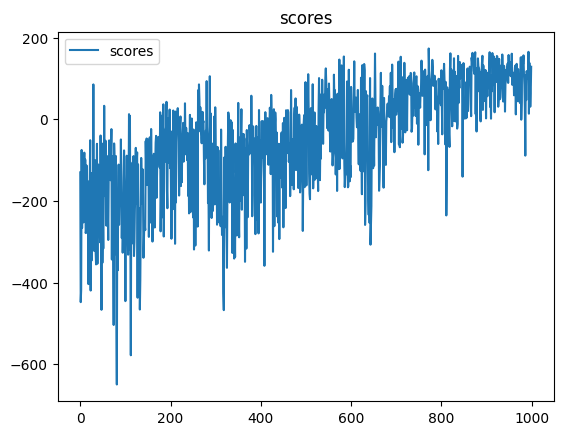

In [9]:
ga.plotting(np.arange(n_games), scores=scores)

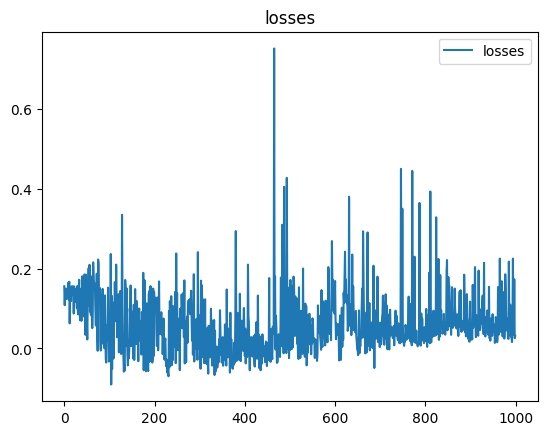

In [10]:
for i in range(len(agent.loss_arr)): 
    agent.loss_arr[i] = agent.loss_arr[i].detach().cpu().numpy()
ga.plotting(np.arange(n_games), losses=agent.loss_arr)

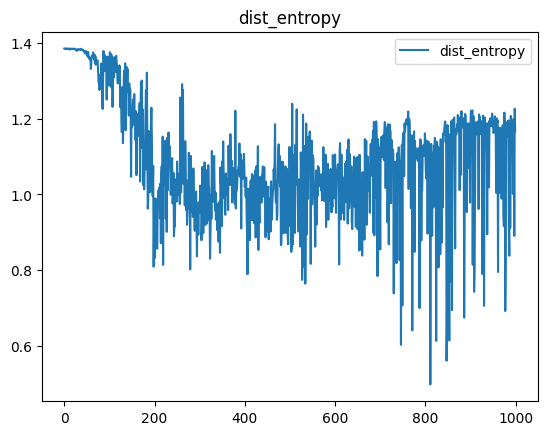

In [11]:
for i in range(len(agent.dist_entropy)): 
    agent.dist_entropy[i] = agent.dist_entropy[i].detach().cpu().numpy()
ga.plotting(np.arange(n_games), dist_entropy=agent.dist_entropy)

In [12]:
env = ga.make('LunarLander-v2', render_mode='human')
agent.play(env)

np.float64(3.7293401500586896)

In [13]:
agent.load(chkpt_dir)
env = ga.make('LunarLander-v2', render_mode='human')
agent.play(env)

np.float64(88.57049695563475)